In [ ]:
#import torch
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal,Normal
import os
os.environ["NGSIM_DIR"] = "/home/surender/Downloads/NGSIM"
os.environ["OPENDD_DIR"] = "/home/surender/Downloads/openDD"
os.environ["CARLA_PATH"] = "/home/surender/Downloads/carlaOld"
import sys
#sys.path.append('/home/surender/Downloads/CARLA_0.9.9.4/PythonAPI/carla/dist')
import carla
import random
import argparse

from carla_real_traffic_scenarios.carla_maps import CarlaMaps
from carla_real_traffic_scenarios.ngsim import NGSimDatasets, DatasetMode
from carla_real_traffic_scenarios.ngsim.scenario import NGSimLaneChangeScenario
from carla_real_traffic_scenarios.opendd.scenario import OpenDDScenario
from carla_real_traffic_scenarios.reward import RewardType
from carla_real_traffic_scenarios.scenario import Scenario

from carla_birdeye_view import BirdViewProducer, BirdViewCropType, PixelDimensions
from PIL import Image
#from IPython.display import clear_output, Image, display, HTML
import cv2

%matplotlib tk
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import threading
import time
import math

In [ ]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [ ]:
#import tensorflow as tf

In [ ]:
#from tensorflow.keras.applications import MobileNet

In [ ]:
#mdl = MobileNet(input_shape=(186, 150, 3),include_top=False,weights="imagenet",pooling=max)

In [ ]:
#mdl.summary()

In [ ]:
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    
    
    print("Device set to : cpu")

In [ ]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [ ]:
from controller import VehiclePIDController

In [ ]:
#torch.backends.cudnn.deterministic = True

In [ ]:
'''
class Flatten(nn.Module):
    """Helper to flatten a tensor."""
    def forward(self, x):
        return x.view(x.size(0), -1)
'''
class Normal(nn.Module):
    """A module that builds a Diagonal Gaussian distribution from means.
    Standard deviations are learned parameters in this module.
    """
    def __init__(self, num_outputs):
        super().__init__()
        # initial variance is e^0 = 1
        self.stds = nn.Parameter(torch.zeros(num_outputs))

    def forward(self, x):
        dist = torch.distributions.Normal(loc=x, scale=self.stds.exp())

        # By default we get the probability of sampling each dimension of the
        # distribution. The full probability is the product of these, or
        # the sum since we're working with log probabilities.
        # So overwrite the log_prob function to handle this for us
        dist.old_log_prob = dist.log_prob
        dist.log_prob = lambda x: dist.old_log_prob(x).sum(-1)

        return dist
    
class AutoEncoder(nn.Module):
    def __init__(self,num_channels=3):
        super(AutoEncoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=4, stride=2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=2, stride=2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, kernel_size=1, stride=1),
            
            nn.MaxPool2d(2, 2)
        )
        
        self.l1 = nn.ConvTranspose2d(16, 16, kernel_size = 8, stride=2)
        self.relu = nn.ReLU()
        self.l2 = nn.ConvTranspose2d(16, 32, kernel_size = 8, stride=2)
        self.l3 = nn.ConvTranspose2d(32, 3, kernel_size = 8, stride=1)
        self.l4 = nn.ConvTranspose2d(3,3,kernel_size = 20,stride = 5)
        self.sig = nn.Sigmoid()
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self,x):
        x = self.encoder(x)
        #x = self.flatten(x)
        #print(x.shape)
        x = self.l1(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.l2(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.l3(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.l4(x)
        
        x = self.sig(x)
        print(x.shape)
        return x
        
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init,hidden_size = 512,num_channels = 5):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        
        self.layerclear = nn.Sequential(
            #nn.Conv2d(num_channels, 32, kernel_size=11, stride=1),
            
            #nn.ReLU(),
            #nn.Conv2d(16, 32, kernel_size=3, stride=2),
            #nn.ReLU(),
            #nn.AvgPool2d(7,7),
            #nn.Flatten(),
            #nn.AvgPool2d(7),
            #nn.Flatten(),
            nn.Linear(1280, 512),
            nn.Dropout(0.4),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            nn.Linear(512,128)
            #nn.ReLU(),
            #nn.Linear(64,action_dim),
        )
        self.actor = nn.Sequential(
            nn.Linear(131, 64),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(64,action_dim),
            nn.Tanh()
        
        )
        self.critic = nn.Sequential(
            nn.Linear(131, 64),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Tanh()
            #nn.Conv2d(num_channels, 16, kernel_size=8, stride=4),
            #nn.ReLU(),
            #nn.Conv2d(16, 32, kernel_size=3, stride=2),
            #nn.ReLU(),
            #nn.AvgPool2d(7,7),
            #nn.Flatten(),
            #nn.AvgPool2d(7),
            #nn.Flatten(),
            #nn.Linear(1280, 256),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            #nn.Linear(256,1),
            #nn.ReLU(),
            #nn.Linear(64,action_dim),
            #nn.Tanh()
            #nn.AvgPool2d(7),
            #nn.Flatten(),
            #nn.Linear(1280, 1),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            #nn.Linear(256,64),
            #nn.ReLU(),
            #nn.Linear(64,1),
            #nn.Tanh()
        
        )
        '''
        self.std = nn.Sequential(
            
            nn.AvgPool2d(7,7),
            nn.Flatten(),
            #
            nn.Linear(1280, 256),
            #nn.ReLU(),
            #nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,1),
            
            nn.Softplus()
        )
        '''
        
        '''
        self.actor = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=8, stride=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(4,2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,1),
            #nn.Conv2d(128, 256, kernel_size=4, stride=1),
            #nn.BatchNorm2d(256),
            #nn.MaxPool2d(2,1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(124416, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,action_dim),
            nn.Tanh()
            
            
        )
        
        self.critic = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=8, stride=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(4,2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,1),
            #nn.Conv2d(128, 256, kernel_size=4, stride=1),
            #nn.BatchNorm2d(256),
            #nn.MaxPool2d(2,1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(124416, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,1),
            nn.Tanh()
            
            
        )
        
        
        #self.l1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2)
        #self.l2 = nn.Conv2d(32, 16, kernel_size=4, stride=2)
        #self.l3 = nn.Conv2d(16, 8, kernel_size=3, stride=1)
        #self.p = nn.MaxPool2d(2, 2)
        '''
        ''''
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=4, stride=2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=4, stride=2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1),
            
            #nn.MaxPool2d(2, 2)
        )
        
        self.l1 = nn.ConvTranspose2d(16, 16, kernel_size = 8, stride=4)
        self.relu = nn.ReLU()
        self.l2 = nn.ConvTranspose2d(16, 32, kernel_size = 8, stride=1)
        self.l3 = nn.ConvTranspose2d(32, 3, kernel_size = 8, stride=2)
        self.sig = nn.Sigmoid()
        
        self.layer1 = nn.Conv2d(num_channels, 32, kernel_size=8, stride=4)
        self.relu = nn.ReLU();
        self.layer2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.layer3 = nn.Conv2d(64, 32, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()
        self.layer4 = nn.Linear(9120,512)
        self.actol = nn.Linear(512, action_dim)
        self.acto = nn.Tanh()
        self.crit = nn.Linear(512, 1)
        '''
        #self.actor = nn.Sequential(self.main,nn.Linear(hidden_size, action_dim))
        #self.critic = nn.Sequential(self.main_two,nn.Linear(hidden_size, 1))
        '''
        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        '''
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            #del self.action_var
            self.action_var = torch.full((self.action_dim,),new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def AutoEncoder(self,x):
        '''
        x = self.encoder(x)
        print(x.shape)
        x = self.l1(x)
        x = self.relu(x)
        print(x.shape)
        x = self.l2(x)
        x = self.relu(x)
        print(x.shape)
        x = self.l3(x)
        x = self.sig(x)
        print(x.shape)
        
        print(x.shape)
        x = self.l1(x)
        print(x.shape)
        x = self.p(x)
        print(x.shape)
        x = self.l2(x)
        print(x.shape)
        x = self.p(x)
        print(x.shape)
        x = self.l3(x)
        print(x.shape)
        x = self.p(x)
        print(x.shape)
        '''
        #x = self.encoder(x)
        #return x
        pass
        

    def forward(self):
        raise NotImplementedError
        '''
        print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.flatten(x)
        print(x.shape)
        x = self.layer4(x)
        print(x.shape)
        a = self.actol(x)
        a = self.acto(a)
        v = self.crit(x)
        return a,v
        '''
        
    def backward(self, x):
        import pdb
        pdb.set_trace()
        return x
    

    def act(self, state):
        
        if self.has_continuous_action_space:
            #x = self.main(state)
            inps1 = state[:,:-3]
            inps2 = state[:,-3:]
            action_m = self.layerclear(inps1)
            #print(action_m,inps2,action_m.shape,inps2.shape)
            inps = torch.cat((action_m,inps2),1)
            action_mean = self.actor(inps)
            
            #action_std = self.std(state)
            #print(action_std)
            #self.set_action_std(torch.mean(action_std))
            #print(action_mean,action_std)
            #cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
            
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            '''
            if len(state.shape) == 3:
                state = state.reshape((1,5,186,150))
            '''
            #x = self.main(state)
            #print(state.shape)
            inps1 = state[:,:-3]
            inps2 = state[:,-3:]
            action_m = self.layerclear(inps1)
            inps = torch.cat((action_m,inps2),1)
            action_mean = self.actor(inps)
            #action_mean = self.actor(state)
            #action_std = self.std(state)
            #print(action_std)
            #print(torch.mean(action_std))
            #self.set_action_std(torch.mean(action_std))
            #var = torch.mean(action_std)
            #print(action_mean.shape)
            action_var = self.action_var.expand_as(action_mean)
            #print(action_var,action_var.shape)
            
            cov_mat = torch.diag_embed(action_var).to(device)
            #print(cov_mat)
            dist = MultivariateNormal(action_mean, cov_mat)
            #print(dist)
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        inps1 = state[:,:-3]
        inps2 = state[:,-3:]
        critic_m = self.layerclear(inps1)
        inps = torch.cat((critic_m,inps2),1)
        #action_mean = self.actor(inps)
        state_values = self.critic(inps)
        #print(state_values,action_mean)
        return action_logprobs, state_values, dist_entropy


In [ ]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init
        self.entropy_c = 0.01
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        
                        {'params': self.policy.critic.parameters(),'lr': lr_critic},
                        {'params': self.policy.layerclear.parameters(),'lr': lr_actor}
                        
                    ])
        

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        #print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                #print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                pass
                #print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        #print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        #print(self.buffer.rewards)
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        #print("I",rewards)
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        #print(rewards,rewards.mean(),rewards.std(unbiased = False))
        rewards = (rewards - rewards.mean()) / (rewards.std(unbiased = False) + 1e-7)
        #print(rewards)
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            for index in BatchSampler(SubsetRandomSampler(range(len(self.buffer.states))), 32, False):
            # Evaluating old actions and values
                #print(index,old_actions[index],old_actions)
                logprobs, state_values, dist_entropy = self.policy.evaluate(old_states[index], old_actions[index])
                #print(state_values)
                # match state_values tensor dimensions with rewards tensor
                state_values = torch.squeeze(state_values)

                #state_values = torch.
                # Finding the ratio (pi_theta / pi_theta__old)
                ratios = torch.exp(logprobs - old_logprobs[index].detach())
                #print(ratios)
                # Finding Spurrogate Loss
                advantages = rewards[index] - state_values.detach()   
                #print(rewards)
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
                #print(state_values)
                #print(state_values.shape)
                # final loss of clipped objective PPO
                #print(rewards.shape,state_values.shape)
                loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards[index]) - 0.01*dist_entropy
                #print(surr1,surr2,state_values,rewards,dist_entropy,loss)
                # take gradient step
                self.optimizer.zero_grad()
                loss.mean().backward()
                self.optimizer.step()
            #self.optimizer2.step()
        if self.entropy_c > 0.001:
            self.entropy_c -= 0.0001
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [ ]:
update_timestep = 1000     # update policy every n timesteps
K_epochs = 40              # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.999                # discount factor

lr_actor = 0.0001       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0 

In [ ]:
def prepare_ngsim_scenario(client: carla.Client, data_mode = "train") -> Scenario:
    data_dir = os.environ.get("NGSIM_DIR")
    #data_dir = os.listdir('/home/surender/Downloads/NGSIM')
    assert data_dir, "Path to the directory with NGSIM dataset is required"
    ngsim_map = NGSimDatasets.list()
    ngsim_dataset = ngsim_map[1]
    client.load_world(ngsim_dataset.carla_map.level_path)
    if data_mode == "train":
        return NGSimLaneChangeScenario(
            ngsim_dataset,
            dataset_mode=DatasetMode.TRAIN,
            data_dir=data_dir,
            reward_type=RewardType.DENSE,
            client=client,
        )
    else:
        return NGSimLaneChangeScenario(
            ngsim_dataset,
            dataset_mode=DatasetMode.VALIDATION,
            data_dir=data_dir,
            reward_type=RewardType.DENSE,
            client=client,
        )

'''
def prepare_opendd_scenario(client: carla.Client) -> Scenario:
    data_dir = os.environ.get("OPENDD_DIR")
    assert data_dir, "Path to the directory with openDD dataset is required"
    maps = ["rdb1", "rdb2", "rdb3", "rdb4", "rdb5", "rdb6", "rdb7"]
    map_name = random.choice(maps)
    carla_map = getattr(CarlaMaps, map_name.upper())
    client.load_world(carla_map.level_path)
    return OpenDDScenario(
        client,
        dataset_dir=data_dir,
        dataset_mode=DatasetMode.TRAIN,
        reward_type=RewardType.DENSE,
        place_name=map_name,
    )

'''
def prepare_ego_vehicle(world: carla.World) -> carla.Actor:
    car_blueprint = world.get_blueprint_library().find("vehicle.audi.a2")

    # This will allow external scripts like manual_control.py or no_rendering_mode.py
    # from the official CARLA examples to take control over the ego agent
    car_blueprint.set_attribute("role_name", "hero")

    # spawn points doesnt matter - scenario sets up position in reset
    ego_vehicle = world.spawn_actor(
        car_blueprint, carla.Transform(carla.Location(0, 0, 500), carla.Rotation())
    )

    assert ego_vehicle is not None, "Ego vehicle could not be spawned"

    # Setup any car sensors you like, collect observations and then use them as input to your model
    return ego_vehicle

In [ ]:
def cmd_carla():
    os.system("DISPLAY= /home/surender/Downloads/carlaOld/CarlaUE4.sh -benchmark -fps=10 -quality-level=Low -opengl -Resx=300 -Resy=300 -NoVSync ")

In [ ]:
def cmd_carla():
    os.system("DISPLAY= /home/surender/Downloads/carlaOld/CarlaUE4.sh -benchmark -fps=5 -quality-level=Low -opengl -Resx=4 -Resy=4 -NoVSync")

In [ ]:
thp = threading.Thread(target = cmd_carla)
thp.start()


In [ ]:
host = "localhost"
port = 2000
client = carla.Client(host,port)

In [ ]:
#torch.squeeze(torch.tensor([[1.4]]))

In [ ]:
scenario = prepare_ngsim_scenario(client)

In [ ]:
world = client.get_world()
spectator = world.get_spectator()
ego_vehicle = prepare_ego_vehicle(world)


In [ ]:
settings = world.get_settings()
settings.no_rendering_mode = True
world.apply_settings(settings)

In [ ]:
input_data= []

In [ ]:
current_frame = 0

In [ ]:
def check_img(img):
    global input_data,current_frame
    c_img = img
    #print(img.frame)
    array = np.frombuffer(img.raw_data, dtype=np.dtype("uint8"))
    #print(array.shape)
    array = np.reshape(array, (img.height, img.width, 4)) # RGBA format
    array = array[:, :, :3] #  Take only RGB
    #print(array.shape)
    #plt.imshow(array)
    
    img = Image.fromarray(array)
    
    #print(img)
    img = img.resize((320,320), Image.ANTIALIAS)
    #print(img)
    input_data = np.array(img)
    current_frame = c_img.frame

In [ ]:
cam_bp = world.get_blueprint_library().find('sensor.camera.rgb')
cam_bp.set_attribute("image_size_x",str(320))
cam_bp.set_attribute("image_size_y",str(320))
cam_bp.set_attribute("fov",str(100))
cam_location = carla.Location(2,0,1)
cam_rotation = carla.Rotation(0,0,0)
cam_transform = carla.Transform(cam_location,cam_rotation)
ego_front_cam = world.spawn_actor(cam_bp,cam_transform,attach_to=ego_vehicle, attachment_type=carla.AttachmentType.Rigid)
#self.rgb_front_listener = ego_cam
ego_front_cam.listen(lambda image: check_img(image))

In [ ]:
from carla_real_traffic_scenarios.artificial_lane_change.scenario import ArtificialLaneChangeScenario

In [ ]:
#als = ArtificialLaneChangeScenario(client = client,cmd_for_changing_lane=r.chauffeur_cmd,speed_range_token="HIGHWAY")

In [ ]:
for i in list(world.get_actors()):
    i.destroy()

In [ ]:
world.tick()

In [ ]:
list(world.get_actors())

In [ ]:
len(list(world.get_actors()))

In [ ]:

scenario.reset(ego_vehicle)

In [ ]:
r = scenario.step(ego_vehicle)

In [ ]:
r

In [ ]:
c = world.tick()

In [ ]:
pid = VehiclePIDController(ego_vehicle)

In [ ]:
k = pid.run_step(30,r.info["scenario_data"]["original_veh_transform"])

In [ ]:
k.steer

In [ ]:
ego_vehicle.apply_control(carla.VehicleControl(throttle=0.2, steer=-0.5))

In [ ]:
r.chauffeur_cmd

In [ ]:
r.reward

In [ ]:
e_v = r.info["scenario_data"]["ego_veh"]

In [ ]:
r.done

In [ ]:
e_v.get_location().y

In [ ]:
r.info["scenario_data"]["original_veh_transform"].location

In [ ]:
scenario.close()

In [ ]:
scenario = prepare_ngsim_scenario(client)

In [ ]:
world = client.get_world()
#spectator = world.get_spectator()
ego_vehicle = prepare_ego_vehicle(world)

In [ ]:
scenario.reset(ego_vehicle)

In [ ]:
r

In [ ]:
scenario._target_lane_waypoint.transform.location.x

In [ ]:
ego_vehicle.get_location().y

In [ ]:
way.location.x -= 100

In [ ]:
way.location.x

In [ ]:
ego_vehicle.get_location().x

In [ ]:
way.location.y += 0.5

In [ ]:
ego_vehicle.get_transform

In [ ]:
way.location.y

In [ ]:
def way_cal(ego_vehicle,val,stabilize = False, actual_waypoint = None):
    way = ego_vehicle.get_transform()
    if (val == 0  or val ==1):
        way.location.x += 100        
    if (val == 2 or val == 5):
        way.location.x += 30
        way.location.y += 7
    if (val == 3 or val == 4):
        way.location.x += 30
        way.location.y -= 7
    return way

In [ ]:
r.info

In [ ]:
import random

In [ ]:
list(world.get_actors())[0].id

In [ ]:
for i in range(20):
    #scenario.reset(ego_vehicle)
    #client.apply_batch([carla.command.DestroyActor(x) for x in list(world.get_actors())])
    #world.tick()
    ids = list(world.get_actors())[0].id
    carla.command.DestroyActor(ids)
    world = client.get_world()
    #spectator = world.get_spectator()
    ego_vehicle = prepare_ego_vehicle(world)
    scenario.reset(ego_vehicle)
    done = False
    c = world.tick()
    way = ego_vehicle.get_transform()
    cmd_buffer = [0]
    stab = False
    aw = None
    speed = 40
    while not done:
        pid = VehiclePIDController(ego_vehicle)
        speed = random.randint(30,50)
        k = pid.run_step(speed,way)
        ego_vehicle.apply_control(carla.VehicleControl(throttle=k.throttle, steer=k.steer, brake = k.brake))
        r = scenario.step(ego_vehicle)
        print(r.reward,done,r.chauffeur_cmd)
        #way = scenario._target_lane_waypoint.transform
        way = r.info["scenario_data"]["original_veh_transform"]
        cmd_buffer.append(r.chauffeur_cmd.value)

        if len(cmd_buffer)>5:
            if sum(cmd_buffer[-5:]) == 0 or sum(cmd_buffer[-5:]) == 5:
                way = scenario._target_lane_waypoint.transform
                way.location.x += 50
                speed = 40

        birdview = birdview_producer.produce(

                agent_vehicle=ego_vehicle  # carla.Actor (spawned vehicle)
                )
        rgb = BirdViewProducer.as_rgb(birdview)
        cv2.imshow('Frame',rgb)
        done = r.done
        if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
        c = world.tick()
    cv2.destroyAllWindows()
    #time.sleep(3)

In [ ]:
r

In [ ]:
birdview = birdview_producer.produce(
            agent_vehicle=ego_vehicle  # carla.Actor (spawned vehicle)
            )
rgb = BirdViewProducer.as_rgb(birdview)
cv2.imshow('Frame',rgb)

if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

In [ ]:
scenario._target_lane_waypoint.transform.location.y

In [ ]:
c

In [ ]:
world.tick()

In [ ]:
plt.imshow(input_data)

In [ ]:
current_frame

In [ ]:
p = PPO(1,2,lr_actor,lr_critic,gamma,K_epochs,eps_clip,True)

In [ ]:
del p

In [ ]:
p.load("Model_CHK4.mdl")

In [ ]:
print(p.policy)

In [ ]:
ae = AutoEncoder(3).to(device)

In [ ]:
img = ae(state)

In [ ]:
img = img.detach().cpu().numpy()

In [ ]:
img = img.reshape((3,320,320))

In [ ]:
img = img.reshape((320,320,3))

In [ ]:
plt.imshow(img)

In [ ]:
from torchsummary import summary

In [ ]:
birdview_producer = BirdViewProducer(
    client,  # carla.Client
    target_size=PixelDimensions(width=224, height=224),
    pixels_per_meter=4,
    crop_type=BirdViewCropType.FRONT_AREA_ONLY
    )

In [ ]:
birdview = birdview_producer.produce(
            agent_vehicle=ego_vehicle  # carla.Actor (spawned vehicle)
            )

In [ ]:
rgb = BirdViewProducer.as_rgb(birdview)
cv2.imshow('Frame',rgb)

if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()


In [ ]:
plt.imshow(birdview[1])

In [ ]:
plt.imshow(birdview[3])

In [ ]:
plt.imshow(birdview[4])

In [ ]:
birdview[1].shape

In [ ]:
a = birdview[0].reshape(1,186,150)
a = np.append(a,birdview[1].reshape(1,186,150),axis=0)
a = np.append(a,birdview[2].reshape(1,186,150),axis=0)
a = np.append(a,birdview[3].reshape(1,186,150),axis=0)
a = np.append(a,birdview[4].reshape(1,186,150),axis=0)

In [ ]:
birdview[0]

In [ ]:
plt.imshow(birdview[3])

In [ ]:
#a[1,:,:] = birdview[3]

In [ ]:
a = rgb.reshape(1,3,186,150)

In [ ]:
a = a/255.

In [ ]:
plt.imshow(a.reshape(3,186,150))

In [ ]:
a = np.append(a,birdview[3].reshape(1,224,224),axis=0)
a = np.append(a,birdview[4].reshape(1,224,224),axis=0)

In [ ]:
plt.imshow(a[2])

In [ ]:
a = rgb.reshape(1,3,224, 224)

In [ ]:
a

In [ ]:
inp = rgb.reshape(1,186,150,3)

In [ ]:
inp = np.append(inp, rgb.reshape(1,186,150,3),axis = 0)

In [ ]:
inp.shape

In [ ]:
cv2.destroyAllWindows()

In [ ]:
action_var = torch.full((2,), 0.9 * 0.9).to(device)

In [ ]:
action_var

In [ ]:
state = torch.FloatTensor(a).to(device)

In [ ]:
state.shape

In [ ]:
action_mean = p.policy.actor(state)


In [ ]:
action_mean

In [ ]:
cov_mat = torch.diag(action_var).unsqueeze(dim=0)


In [ ]:
cov_mat

In [ ]:
dist = MultivariateNormal(action_mean, cov_mat)

In [ ]:
dist.entropy()

In [ ]:
action = dist.sample()


In [ ]:
action

In [ ]:
action

In [ ]:
action_logprob = dist.log_prob(action)

In [ ]:
action_logprob

In [ ]:
b = mdl(inp).numpy()

In [ ]:
b.shape

In [ ]:
a.shape

In [ ]:
b.shape

In [ ]:
a.reshape(a.shape[0],20480).shape

In [ ]:
b.reshape(b.shape[0],20480).shape

In [ ]:
rgb.shape

In [ ]:
ego_vehicle.get_location().y 

In [ ]:
scenario._target_lane_waypoint.transform.location.y - ego_vehicle.get_location().y 

In [ ]:
scenario._target_lane_waypoint.transform.location.x - ego_vehicle.get_location().x 

In [ ]:
ego_vehi

In [ ]:
v = ego_vehicle.get_velocity()

In [ ]:
v.z

In [ ]:
v.x

In [ ]:
v.y

In [ ]:
ego_vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer=0.0))


In [ ]:
scenario.step(ego_vehicle)

In [ ]:
world.tick()

In [ ]:
birdview = birdview_producer.produce(
            agent_vehicle=ego_vehicle  # carla.Actor (spawned vehicle)
            )
rgb = BirdViewProducer.as_rgb(birdview)
cv2.imshow('Frame',rgb)

if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()


In [ ]:
cv2.destroyAllWindows()

In [ ]:
plt.imshow(birdview[0]) #Full Road Greyed out

In [ ]:
plt.imshow(birdview[1])  #Lanes

In [ ]:
plt.imshow(birdview[2]) #Centerlines

In [ ]:
plt.imshow(birdview[3])#Other vehicles

In [ ]:
plt.imshow(birdview[4])# Ego agent

In [ ]:
in_data = birdview[:5,:,:]

In [ ]:
in_data.shape

In [ ]:
in_data = in_data.reshape((1,5,186,150))

In [ ]:
np.max(in_data)

In [ ]:
in_data.shape

In [ ]:
p.select_action(state)

In [ ]:
p.policy.actor(state.to(device)).shape

In [ ]:
p.policy.forward(torch.FloatTensor(in_data).to(device))

In [ ]:
import math

In [ ]:
p.policy.actor.parameters()

In [ ]:
with torch.no_grad():
    state = torch.FloatTensor(in_data)

In [ ]:
state

In [ ]:
state.shape

In [ ]:
k = p.policy.AutoEncoder(state)

In [ ]:
ae = AutoEncoder(3).to(device)
optimizer = torch.optim.Adam([
                        {'params': ae.parameters(), 'lr': 0.003}
])

criterion = nn.MSELoss()



In [ ]:
inp = torch.cat((state,state), 0)

In [ ]:
inp.shape[0]

In [ ]:
del inp_tensor,outputs

In [ ]:
A =  state

In [ ]:
A/255.

In [ ]:
in_data

In [ ]:
state.shape

In [ ]:
A.shape

In [ ]:
epochs = 300
min_batch_size = 32
inp_tensor = state
ep_list = []
loss_list = []
for epoch in range(epochs):
    step = 0
    scenario.reset(ego_vehicle)
    c = world.tick()
    done = False
    total_r = 0
    val = 0
    
    while not done:
        in_data = input_data.reshape((1,3,320,320))
        with torch.no_grad():
            st = torch.FloatTensor(in_data)
        ego_vehicle.apply_control(carla.VehicleControl(throttle=0.5))
        try:
            cmd, reward, done, _ = scenario.step(ego_vehicle)
        except:
            break
        c = world.tick()
        inp_tensor = torch.cat((inp_tensor,st),0)
        del st
        if inp_tensor.shape[0] >= min_batch_size:
            break
        step += 1
    if inp_tensor.shape[0] >= min_batch_size:
            optimizer.zero_grad()
            A = inp_tensor/255.
            #A -= A.min(1, keepdim=True)[0]
            #A /= A.max(1, keepdim=True)[0]
            inp_tensor = A
            outputs = ae(inp_tensor.to(device))
            loss = criterion(outputs, inp_tensor.to(device))
            loss.backward()
            optimizer.step()
            print("EPOCH:",epoch,"LOSS:",loss.item())
            ep_list.append(epoch)
            loss_list.append(loss.item())
            del inp_tensor,outputs,A
            inp_tensor = state

In [ ]:
BCE_loss = [ep_list,loss_list]

In [ ]:
MSE_loss_1 = [ep_list,loss_list]

In [ ]:
import pickle
f = open("MSE1.pkl",'wb')
pickle.dump(MSE_loss_1,f)
f.close()

In [ ]:
#plt.ylim(0,1)
plt.plot(ep_list,loss_list)

In [ ]:
in_data = state.detach().cpu().numpy()

In [ ]:
i_img = in_data.reshape((3,320,320)).reshape((320,320,3))

In [ ]:
plt.imshow(input_data)

In [ ]:
plt.imshow(i_img)

In [ ]:
state

In [ ]:
out =ae(state.to(device))

In [ ]:
scenario._target_lane_waypoint.transform.location.y

In [ ]:
ego_vehicle.get_location().y

In [ ]:
r = scenario.step(ego_vehicle)

In [ ]:
r

In [ ]:
oupp = out.detach().cpu().numpy()

In [ ]:
o_img = oupp.reshape((3,320,320)).reshape((320,320,3))

In [ ]:
plt.imshow(o_img)

In [ ]:
k.shape

In [ ]:
total_reward_list = []
epoch_list = []
step_list = []

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torchvision.models as models
mobilenet = models.mobilenet_v2(pretrained=True).to(device)

In [ ]:
mobilenet.classifier

In [ ]:
mobilenet.features

In [ ]:
in_data = a

In [ ]:
in_data  =in_data/255.

In [ ]:
with torch.no_grad():
    in_data = torch.FloatTensor(in_data).to(device)
    in_data = mobilenet.features(in_data)
    in_data = nn.AvgPool2d(7,7)(in_data)
    in_data = nn.Flatten()(in_data)
    in_data = in_data.detach().cpu().numpy()

In [ ]:
in_data.shape

In [ ]:
inps = np.array([0,0,1])

In [ ]:
in_data[:,]

In [ ]:
ap = np.concatenate((in_data[0],inps)).reshape(1,1283)

In [ ]:
with torch.no_grad():
    st = torch.FloatTensor(ap).to(device)

In [ ]:
st[:,-3:]

In [ ]:
f = in_data.reshape(128,100,3)

In [ ]:
plt.imshow(f)

In [ ]:
p.select_action(in_data)

In [ ]:
def PID_Controller(cmd,e_v,steer):
    speed_limit = 60
    min_speed = 10
    v = e_v.get_velocity()
    kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
    if kmh > speed_limit:
        throttle = 0.1 + + random.random()/8
        brake = 0.9
    elif kmh < min_speed:
        throttle = 0.4 + random.random()/8
        brake = 0.0
    else:
        throttle = 0.1 + random.random()/8
        brake = 0
    
    if (val == 0  or val ==1):
        #Go Straight
        
        if abs(steer)> 0.1:
            
            throttle = 0.1 +  random.random()/8
            
                
            brake = (kmh-10)/50
            
        else:
            throttle = (60-kmh)/50 + random.random()/8
            brake = 0
            
        
        #s_clip_n = -0.15
        #s_clip_p = 0.15
        #t_clip_n = 0.4
        #t_clip_p = 1.0

    if (val == 2 or val == 5):
        # Go right
        
        if steer < 0:
            brake = (kmh-10)/50
            throttle = 0.1
        if steer > 0:
            throttle = (60-kmh)/50 + random.random()/8
            brake = 0
        #s_clip_n = 0.25
        #s_clip_p = 0.6
        #t_clip_n = 0.0
        #t_clip_p = 0.4

    if (val == 3 or val == 4):
        # Go Left
        if steer < 0 :
            throttle = (60-kmh)/50 + random.random()/8
            brake = 0
        if steer > 0 :
            brake = (kmh-10)/50
            throttle = 0.1
        #s_clip_n = -0.6
        #s_clip_p = -0.25
        #t_clip_n = 0.0
        #t_clip_p = 0.4
    if throttle <= 0:
        throttle = 0.05 + random.random()/50
    if throttle >= 0.4:
        throttle = 0.4 + random.random()/8
    if brake < 0:
        brake = 0
    if brake >= 1:
        brake = 0.9
    return throttle,brake

In [ ]:
import random
random.random()

In [ ]:
ego_vehicle.get_transform()

In [ ]:
def way_cal(ego_vehicle,val,stabilize = False, actual_waypoint = None):
    way = ego_vehicle.get_transform()
    if (val == 0  or val ==1):
        way.location.x += 100        
    if (val == 2 or val == 5):
        way.location.x += 100
        way.location.y += 7
    if (val == 3 or val == 4):
        way.location.x += 100
        way.location.y -= 7
    return way

In [ ]:
c = torch.arange(10).reshape(1,10)

In [ ]:
c = c.detach().numpy()

In [ ]:
d = torch.arange(4).reshape(4).detach().numpy()

In [ ]:
d

In [ ]:
c[0]

In [ ]:
d

In [ ]:
np.concatenate((c,d))

In [ ]:
torch.cat()

In [ ]:
epochs = 500
freq = 5
freq_n = 3
update_freq = 500
decay_freq = 1000
decay_c = 1000
#val = 0
min_r_avg = -1
steer_w = 1
min_steer_w = 0
steer_decay = 0.1

for epoch in range(0,epochs):
    step = 0
    #del ego_vehicle
    ids = list(world.get_actors())[0].id
    carla.command.DestroyActor(ids)
    world = client.get_world()
    #spectator = world.get_spectator()
    ego_vehicle = prepare_ego_vehicle(world)
    #scenario.close()
    #scenario = prepare_ngsim_scenario(client)
    
    #time.sleep(3)
    #world = client.get_world()
    #spectator = world.get_spectator()
    #client.reload_world()
    
    #ego_vehicle = prepare_ego_vehicle(world)
    
    scenario.reset(ego_vehicle)
    c = world.tick()
    #way = scenario._target_lane_waypoint.transform
    
    #c = world.tick()
    done = False
    total_r = 0
    val = 0
    way = way_cal(ego_vehicle,val)
    
    t_clip_n = 0.0
    t_clip_p = 1.0
    
    s_clip_n = -1.0
    s_clip_p = 1.0
    cmd_buffer = [0]
    yaw_buffer = [0]
    while not done:
        '''
        while True:
            #print(current_frame,c)
            if current_frame >= c:
                #print(current_frame,c)
                break
        '''
        birdview = birdview_producer.produce(
            agent_vehicle=ego_vehicle  # carla.Actor (spawned vehicle)
            )
        #a = birdview[0].reshape(1,186,150)
        #a = np.append(a,birdview[1].reshape(1,186,150),axis=0)
        #a = np.append(a,birdview[2].reshape(1,186,150),axis=0)
        #a = np.append(a,birdview[3].reshape(1,186,150),axis=0)
        #a = np.append(a,birdview[4].reshape(1,186,150),axis=0)
        #a = np.append(a,birdview[4].reshape(1,224,224),axis=0)
        rgb = BirdViewProducer.as_rgb(birdview)/255.
        #in_data = a.reshape(1,5,186,150)
        in_data = rgb.reshape(1,3,224,224)/255.
        
        with torch.no_grad():
            in_data = torch.FloatTensor(in_data).to(device)
            in_data = mobilenet.features(in_data)
            in_data = nn.AvgPool2d(7,7)(in_data)
            in_data = nn.Flatten()(in_data)
            in_data = in_data.detach().cpu().numpy()
        #in_data = mdl(in_data).numpy()
        #in_data = in_data.reshape(in_data.shape[0],62720)
        #in_data = in_data.reshape((1,5,186,150))
        #in_data = input_data.reshape((1,3,320,320))
        #print(in_data.shape)
        if val == 0 or val == 1:
            inps= [0,0,1]
        if val == 2 or val == 5:
            inps = [0,1,0]
        if val == 4 or val ==3:
            inps = [1,0,0]
        inps = np.array(inps)
        ap = np.concatenate((in_data[0],inps)).reshape(1,1283)
        
        action = p.select_action(ap)
        #print(action)
        
        '''
        if (val == 0  or val ==1):
            s_clip_n = -0.15
            s_clip_p = 0.15
            t_clip_n = 0.4
            t_clip_p = 1.0
        
        if (val == 2 or val == 5):
            s_clip_n = 0.25
            s_clip_p = 0.8
            t_clip_n = 0.0
            t_clip_p = 0.4
        
        if (val == 3 or val == 4):
            s_clip_n = -0.8
            s_clip_p = -0.25
            t_clip_n = 0.0
            t_clip_p = 0.4
        '''
            
        
        #t_clip_n = 0.0
        #t_clip_p = 0.7

        #s_clip_n = -0.6
        #s_clip_p = 0.6  
        steer = action[1]
        _speed = np.clip(action[0], -1,1)
        speed = ((_speed + 1)/2)*50 + 10
        
        '''
        brake = 0
        throttle = 0
        if action[0] <0:
            brake = action[0]
            throttle = 0
        else:
            throttle = action[0]
            brake = 0
        '''
        '''
        if epoch > 400:
            if (val == 0  or val ==1):
                s_clip_n = -0.15
                s_clip_p = 0.15
                t_clip_n = 0.4
                t_clip_p = 1.0

            if (val == 2 or val == 5):
                s_clip_n = 0.25
                s_clip_p = 0.6
                t_clip_n = 0.0
                t_clip_p = 0.4

            if (val == 3 or val == 4):
                s_clip_n = -0.6
                s_clip_p = -0.25
                t_clip_n = 0.0
                t_clip_p = 0.4
        '''
        #if epoch < 20:
        #print(throttle,steer,brake)
        pid = VehiclePIDController(ego_vehicle)
        
        k = pid.run_step(speed,way)
        throttle = k.throttle
        brake = k.brake
        
        avg_steer = steer
        ego_vehicle.apply_control(carla.VehicleControl(throttle=throttle, steer=np.clip(avg_steer, s_clip_n, s_clip_p),brake=brake))
        
        #ego_vehicle.apply_control(carla.VehicleControl(throttle=np.clip(throttle, t_clip_n, t_clip_p), steer=np.clip(action[1], s_clip_n, s_clip_p)))#,brake=np.clip(brake, 0.0, 1.0)))
        
        
        
        cmd, reward, done, _ = scenario.step(ego_vehicle)
        '''
        if reward < 0 :
            reward = -0.1
        '''
        
        val = cmd.value
        way = way_cal(ego_vehicle,val)
        cmd_buffer.append(val)
        yaw_buffer.append(ego_vehicle.get_transform().rotation.yaw)
        if len(cmd_buffer) > 5:
            if sum(cmd_buffer[-5:]) == 0 and _['on_target_lane'] and abs(sum(yaw_buffer[-2:])/2)<=10:
                reward = 1
                done = True
        
        if reward >=0.9:
            print("Close to win")
        if reward >= 1:
            print("Its a win")
            #p.save("WinModel"+str(epoch)+".mdl")
        #way = _["scenario_data"]["original_veh_transform"]
        #way = scenario._target_lane_waypoint.transform  
        
        
        #print(action[0],action[1])
        #print(done)
        #if done:
        #    print(_)
        #print(_)
        '''
        if (val == 0  or val ==1):
            if action[0] > 0.0:
                reward += 0.01
            if action[1] < 0.1 and action[1]> -0.1:
                reward += 0.01
                

        if (val == 2 or val == 5):
            if action[0] <0.1:
                reward += 0.01
            if action[1] > 0.0:
                reward += 0.01

        if (val == 3 or val == 4):
            if action[0] < 0.1:
                reward += 0.01
            if action[1] < 0.0:
                reward += 0.01
        '''
        #reward += step
        '''
        v = ego_vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
        
        if kmh < 60 & kmh > 0.2:
            #done = False
            reward += 1 #-1
            # Reward lighter steering when moving
            if np.abs(action[1]) < 0.3:
                reward += 1
            elif np.abs(action[1]) > 0.5 and np.abs(action[1]) < 0.9:
                reward -= 0.1
            elif np.abs(action[1]) >= 0.9:
                reward -= 0.2
        elif kmh < 0.2:
            reward -= 0.1
        else:
            #print("Maybe never")
            reward += 0.01
            if np.abs(action[1]) < 0.3:
                reward += 0.12
            # Reduce score for heavy steering
            if np.abs(action[1]) > 0.5 and np.abs(action[1]) < 0.9:
                reward -= 0.17
            elif np.abs(action[1]) >= 0.9:
                reward -= 0.21
        '''
        '''
        rgb = BirdViewProducer.as_rgb(birdview)
        cv2.imshow('Frame',rgb)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        '''
        p.buffer.rewards.append(reward)
        p.buffer.is_terminals.append(done)
        
        total_r += reward
        step += 1
        
        '''
        if step % freq ==0 :
            print(step)
            p.update()
        
        if step % freq_n == 0:
            p.decay_action_std(0.05,0.1)
        
        
        '''
        world.tick()
    #total_r += step/10
    if epoch > 50:
        
        if sum(total_reward_list[-50:])/len(total_reward_list[-50:]) > min_r_avg or sum(step_list) > decay_freq:
            decay_freq += decay_c
            #decay_c -= 50
            print("Decaying:",p.action_std)
            p.decay_action_std(0.01,0.1)
            
            min_r_avg = sum(total_reward_list[-50:])/len(total_reward_list[-50:])
    if len(p.buffer.states)> update_freq:
            print(steer,avg_steer)
            print("Update with batches:",len(p.buffer.states))
            p.update()
            if steer_w > min_steer_w +0.1:
                steer_w -= steer_decay

    else:
            print(total_r,epoch,step)
            total_reward_list.append(total_r)
            epoch_list.append(epoch)
            step_list.append(step)
            continue
    #except Exception as e:
        #print("Error:",e)
        #pass
    
    cv2.destroyAllWindows()
    print(total_r,epoch,step)
    total_reward_list.append(total_r)
    epoch_list.append(epoch)
    step_list.append(step)
    

In [ ]:
a = torch.arange(10).reshape(1,10)
b = torch.arange(100).reshape(1,100)

In [ ]:
a.shape

In [ ]:
torch.cat((a,b),1)

In [ ]:
print("Decaying:",p.action_std)

In [ ]:
_['scenario_data']['original_to_ego_distance']

In [ ]:
total_reward_list[-10:]

In [ ]:
val_reward = []
val_success = []
for i in range(50):
    t_clip_n = 0.0
    t_clip_p = 1.0

    s_clip_n = -1.0
    s_clip_p = 1.0

    step = 0
    scenario = prepare_ngsim_scenario(client,"Val")
    world = client.get_world()
    spectator = world.get_spectator()
    ego_vehicle = prepare_ego_vehicle(world)

    scenario.reset(ego_vehicle)
    c = world.tick()
    way = ego_vehicle.get_transform()
    done = False
    reward = 0
    val = 0
    cmd_buffer = [0]
    yaw_buffer = [0]
    while not done:

            birdview = birdview_producer.produce(
                agent_vehicle=ego_vehicle  # carla.Actor (spawned vehicle)
                )
            a = birdview[0].reshape(1,186,150)
            a = np.append(a,birdview[1].reshape(1,186,150),axis=0)
            a = np.append(a,birdview[2].reshape(1,186,150),axis=0)
            a = np.append(a,birdview[3].reshape(1,186,150),axis=0)
            a = np.append(a,birdview[4].reshape(1,186,150),axis=0)
            #a = np.append(a,birdview[4].reshape(1,224,224),axis=0)
            #rgb = BirdViewProducer.as_rgb(birdview)/255.
            in_data = a.reshape(1,5,186,150)

            action = p.select_action(in_data)

            steer = action[1]
            _speed = np.clip(action[0], -1,1)
            speed = ((_speed + 1)/2)*50 + 10



            pid = VehiclePIDController(ego_vehicle)
            k = pid.run_step(speed,way)
            throttle = k.throttle
            brake = k.brake

            avg_steer = steer
            ego_vehicle.apply_control(carla.VehicleControl(throttle=throttle, steer=np.clip(avg_steer, s_clip_n, s_clip_p),brake=brake))

            #ego_vehicle.apply_control(carla.VehicleControl(throttle=np.clip(throttle, t_clip_n, t_clip_p), steer=np.clip(action[1], s_clip_n, s_clip_p)))#,brake=np.clip(brake, 0.0, 1.0)))



            cmd, reward, done, _ = scenario.step(ego_vehicle)
            '''
            if reward < 0 :
                reward = -0.1
            '''



            print(reward, cmd, _['scenario_data']['original_to_ego_distance'], throttle,steer)

            val = cmd.value
            cmd_buffer.append(val)
            yaw_buffer.append(ego_vehicle.get_transform().rotation.yaw)
            if len(cmd_buffer) > 10:
                if sum(cmd_buffer[-10:]) == 0 and _['on_target_lane'] and abs(sum(yaw_buffer[-5:])/5)<=10:
                    reward = 1
                    done = True

            if reward >=0.9:
                print("Close to win")
            if reward >= 1:
                print("Its a win")
                #p.save("WinModel"+str(epoch)+".mdl")
            way = _["scenario_data"]["original_veh_transform"]
            #way = scenario._target_lane_waypoint.transform 
            '''
            rgb = BirdViewProducer.as_rgb(birdview)
            cv2.imshow('Frame',rgb)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            '''
            c = world.tick()
    if reward >0.9:
        val_reward.append(reward)
        val_success.append(1)
    else:
        val_reward.append(reward)
        val_success.append(0)

In [ ]:
_['on_target_lane']

In [ ]:
sum(val_success)/len(val_success)

In [ ]:
ego_vehicle.get_transform().rotation.yaw

In [ ]:
_['scenario_data']['original_veh_transform'].rotation.yaw

In [ ]:
p.load("Model_CHK_TorchEasy.mdl")

In [ ]:
p.action_std = 0.02

In [ ]:
p.decay_action_std(0.01,0.01)

In [ ]:
p.action_std

In [ ]:
reward

In [ ]:
cv2.destroyAllWindows()

In [ ]:
int(2.5e5)

In [ ]:
scenario.reset(ego_vehicle)

In [ ]:
scenario.step(ego_vehicle)

In [ ]:
ego_vehicle.get_location().x

In [ ]:
ego_vehicle = prepare_ego_vehicle(world)

In [ ]:
world = client.get_world()

In [ ]:
world.tick()

In [ ]:
ego_vehicle.apply_control(carla.VehicleControl(throttle=0.7, steer=0.1))

In [ ]:
torch.seed()

In [ ]:
History = [epoch_list,total_reward_list,step_list]

In [ ]:
len(epoch_list)

In [ ]:
len(epoch_list)

In [ ]:
import pickle
f = open("History00.pkl",'wb')
pickle.dump(History,f)
f.close()

In [ ]:
p.save("Model_Best.mdl")

In [ ]:
len(total_reward_list)

In [ ]:
epoch_list = epoch_list[500:]
total_reward_list = total_reward_list[500:]
step_list = step_list[500:]

In [ ]:
#plt.ylim(-2,1)
plt.plot(epoch_list,total_reward_list)

In [ ]:
cv2.destroyAllWindows()

In [ ]:
320*320*3

In [ ]:
input_data

In [ ]:
in_data

In [ ]:
in_data = input_data.reshape((1,3,320,320))

In [ ]:
del p

In [ ]:
p.select_action(in_data)

In [ ]:
p.buffer.actions

In [ ]:
p.buffer.rewards

In [1]:
import glob


In [41]:
l = glob.glob('Hi/*3.pkl')

In [42]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [43]:
l

['Hi/History_345_3.pkl',
 'Hi/History_667_3.pkl',
 'Hi/History_2690_3.pkl',
 'Hi/History_2809_3.pkl',
 'Hi/History_1322_3.pkl',
 'Hi/History_1676_3.pkl',
 'Hi/History_1140_3.pkl',
 'Hi/History_836_3.pkl',
 'Hi/History_2571_3.pkl',
 'Hi/History_231_3.pkl',
 'Hi/History_1984_3.pkl',
 'Hi/History_2752_3.pkl',
 'Hi/History_1613_3.pkl',
 'Hi/History_173_3.pkl',
 'Hi/History_611_3.pkl',
 'Hi/History_405_3.pkl',
 'Hi/History_283_3.pkl',
 'Hi/History_1925_3.pkl',
 'Hi/History_2280_3.pkl',
 'Hi/History_1198_3.pkl',
 'Hi/History_1505_3.pkl',
 'Hi/History_458_3.pkl',
 'Hi/History_61_3.pkl',
 'Hi/History_1079_3.pkl',
 'Hi/History_2511_3.pkl',
 'Hi/History_2390_3.pkl',
 'Hi/History_2039_3.pkl',
 'Hi/History_553_3.pkl',
 'Hi/History_2157_3.pkl',
 'Hi/History_725_3.pkl',
 'Hi/History_2335_3.pkl',
 'Hi/History_1257_3.pkl',
 'Hi/History_779_3.pkl',
 'Hi/History_1802_3.pkl',
 'Hi/History_2631_3.pkl',
 'Hi/History_1738_3.pkl',
 'Hi/History_1559_3.pkl',
 'Hi/History_1440_3.pkl',
 'Hi/History_2449_3.pkl',


In [ ]:
i.split('/')

In [44]:
hist = {}
for i in l:
    f = open(i,'rb')
    s = pickle.load(f)
    f.close()
    n = i.split('/')[1]
    n = n.split('.')[0]
    n = n.split('_')
    if n[2] in hist.keys():
        pass
    else:
        hist[n[2]] = {}
    hist[n[2]][n[1]] = s 

In [25]:
hist

{'3': {'345': [[283,
    284,
    285,
    286,
    287,
    288,
    289,
    290,
    291,
    292,
    293,
    294,
    295,
    296,
    297,
    298,
    299,
    300,
    301,
    302,
    303,
    304,
    305,
    306,
    307,
    308,
    309,
    310,
    311,
    312,
    313,
    314,
    315,
    316,
    317,
    318,
    319,
    320,
    321,
    322,
    323,
    324,
    325,
    326,
    327,
    328,
    329,
    330,
    331,
    332,
    333,
    334,
    335,
    336,
    337,
    338,
    339,
    340,
    341,
    342,
    343,
    344],
   [-0.09999999999999998,
    1.7,
    -0.6,
    -0.6,
    -1.0,
    1.8,
    -1.0,
    1.5,
    -0.7,
    -1.1,
    -0.5999999999999999,
    1.6,
    -0.9,
    -0.4,
    -0.6,
    -1.0,
    -0.5,
    -0.19999999999999996,
    -0.6000000000000001,
    -0.9,
    -0.19999999999999996,
    -0.7,
    1.7,
    1.8,
    -1.0,
    -1.0,
    -1.0,
    -0.8,
    1.8,
    -0.6000000000000001,
    1.9,
    -0.09999999999999998,
    1.7,

In [ ]:
if ('w','2000') in hist.keys():
    print("HI")

In [ ]:
hist

In [45]:
epoch_list_0 = [] 

In [ ]:
sorted([int(x) for x in hist['0'].keys()])

In [46]:
for i in sorted([int(x) for x in hist['3'].keys()]):
    epoch_list_0 += hist['3'][str(i)][0]

In [ ]:
hist['0']['500'][0]

In [54]:
len(epoch_list_0)

10059

In [47]:
reward_list_0 = []

for i in sorted([int(x) for x in hist['3'].keys()]):
    reward_list_0 += hist['3'][str(i)][1]

In [ ]:
reward_list_0

In [48]:
step_list_0 = []
for i in sorted([int(x) for x in hist['3'].keys()]):
    step_list_0 += hist['3'][str(i)][2]

In [ ]:
step_list_0

In [ ]:
epoch_list_1 = []
for i in sorted([int(x) for x in hist['1'].keys()]):
    epoch_list_1 += hist['1'][str(i)][0]
reward_list_1 = []
for i in sorted([int(x) for x in hist['1'].keys()]):
    reward_list_1 += hist['1'][str(i)][1]
step_list_1 = []
for i in sorted([int(x) for x in hist['1'].keys()]):
    step_list_1 += hist['1'][str(i)][2]

In [ ]:
final_epoch_list = epoch_list_0 + [x + len(epoch_list_0) for x in epoch_list_1]
final_reward_list = reward_list_0 + reward_list_1
final_step_list = step_list_0 + step_list_1

In [49]:
final_epoch_list = epoch_list_0
final_reward_list = reward_list_0
final_step_list = step_list_0

In [ ]:
print(len(final_epoch_list))
print(len(final_reward_list))
len(final_step_list)

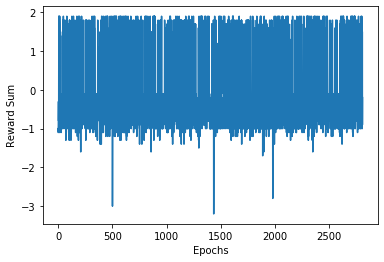

In [50]:
plt.xlabel("Epochs")
plt.ylabel("Reward Sum")
plt.plot(final_epoch_list,final_reward_list)

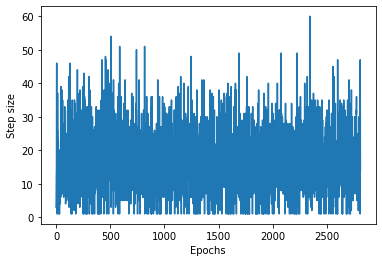

In [51]:
plt.xlabel("Epochs")
plt.ylabel("Step size")
plt.plot(final_epoch_list,final_step_list)

In [20]:
sorted([int(x) for x in hist['1'].keys()])[28]

811

In [90]:
sorted(hist['0'].keys())

['10024',
 '10059',
 '10092',
 '1011',
 '10122',
 '10151',
 '10185',
 '10214',
 '10244',
 '10273',
 '10307',
 '10342',
 '10375',
 '10405',
 '10441',
 '1045',
 '10472',
 '10503',
 '10539',
 '10568',
 '10600',
 '10633',
 '10665',
 '10693',
 '10726',
 '10757',
 '10792',
 '1080',
 '10821',
 '10847',
 '10871',
 '10901',
 '10930',
 '10957',
 '1118',
 '112',
 '1152',
 '1185',
 '1214',
 '1246',
 '1278',
 '1308',
 '1337',
 '1369',
 '138',
 '1395',
 '1424',
 '1449',
 '1474',
 '1508',
 '1540',
 '1569',
 '1589',
 '1616',
 '1645',
 '166',
 '1678',
 '1704',
 '1730',
 '1758',
 '1780',
 '1805',
 '1827',
 '1858',
 '1881',
 '1904',
 '1934',
 '194',
 '1957',
 '1978',
 '2002',
 '2028',
 '2051',
 '2088',
 '2116',
 '2143',
 '2169',
 '2194',
 '2222',
 '225',
 '2250',
 '2275',
 '2302',
 '2333',
 '2363',
 '2390',
 '2422',
 '2448',
 '2477',
 '2506',
 '251',
 '2532',
 '2558',
 '2585',
 '26',
 '2615',
 '2639',
 '2662',
 '2688',
 '2713',
 '274',
 '2745',
 '2772',
 '2802',
 '2828',
 '2855',
 '2885',
 '2913',
 '2939

In [52]:
val_list = []
ep_list = []
for i in sorted([int(x) for x in hist['3'].keys()]):
    ep_list.append(i)
    val_list.append(hist['3'][str(i)][3])

In [53]:
epochs = list(range(len(val_list)))

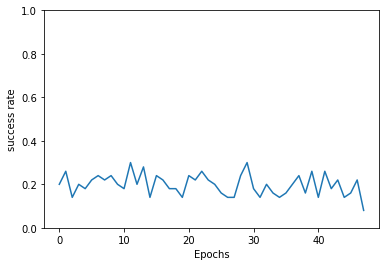

In [54]:
plt.ylim(0,1.0)
#plt.xlim(0,1000)
plt.xlabel("Epochs")
plt.ylabel("success rate")
plt.plot(epochs,val_list)

In [88]:
final_epoch_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [86]:
epochs[310:320]

[310, 311, 312, 313, 314, 315, 316, 317, 318, 319]

In [93]:
val_list[310:330]

[0.14,
 0.08,
 0.14,
 0.18,
 0.32,
 0.16,
 0.12,
 0.18,
 0.24,
 0.12,
 0.18,
 0.14,
 0.26,
 0.2,
 0.12,
 0.16,
 0.18,
 0.1,
 0.1,
 0.18]

In [60]:
len(val_list)

349

In [ ]:
np.mean(final_reward_list)

In [ ]:
np.mean(final_step_list)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(np.array(epoch_list).reshape(-1,1),np.array(total_reward_list))

In [ ]:
model.coef_

In [ ]:
x = list(range(0,7000))

In [ ]:
y = model.predict(np.array(x).reshape(-1,1))

In [ ]:
x = epoch_list
y= total_reward_list

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.ylim(-2.0,2.0)
plt.plot(x,y)

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Steps")
plt.ylim(0.0,10.0)
plt.plot(x,y)

In [ ]:
f = open("History_5500_1.pkl",'rb')
s = pickle.load(f)
f.close()

In [ ]:
e = s[0]
r = s[1]
t = s[2]

In [ ]:
plt.plot(e,r)

In [ ]:
plt.plot(e,t)